In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0059.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0024.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0232.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0286.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0233.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0123.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0150.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-piTr_0009.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0078.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0283.jpg
/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/pituitary/Te-pi_0084.j

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Download the dataset

In [3]:
# Classes we have in our data set.
total_classes = os.listdir("/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data")
total_classes

['pituitary', 'notumor', 'meningioma', 'glioma']

In [4]:
# Total number of images per class.
images_path = Path("/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* pituitary = 300 images
* notumor = 405 images
* meningioma = 306 images
* glioma = 300 images


In [5]:
# random
import random
import cv2

# Warnings
import warnings
warnings.filterwarnings("ignore")

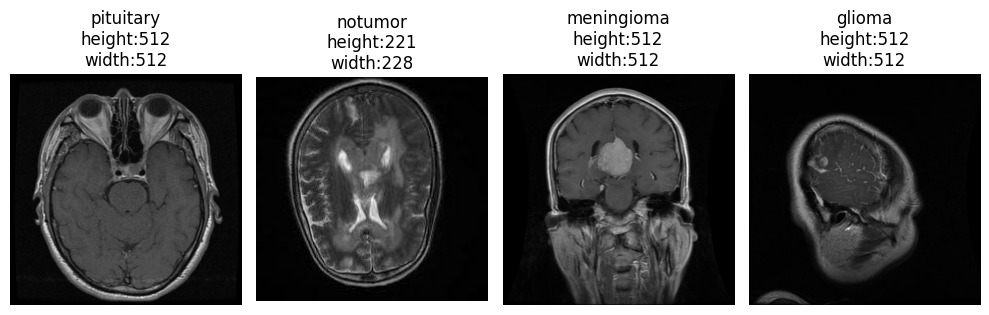

In [6]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1311 files belonging to 4 classes.
Using 1049 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1311 files belonging to 4 classes.
Using 262 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


### Visualize the data

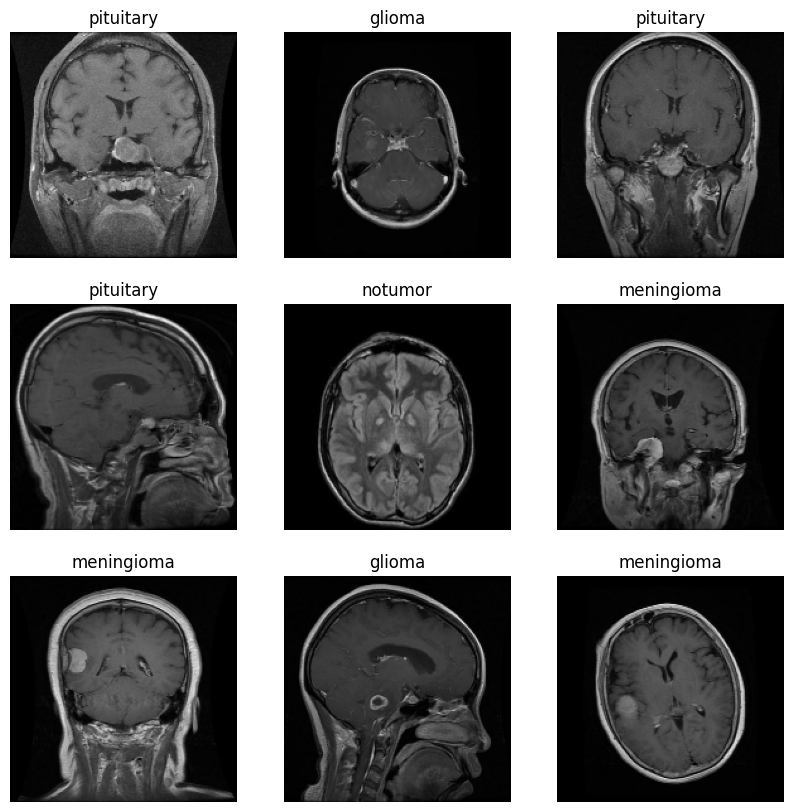

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.99989396


### Create the Model

In [16]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

### Compile the Model

In [17]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the Model

In [19]:
epochs = 10 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
33/33 [==============================] - 7s 67ms/step - loss: 1.1179 - accuracy: 0.5205 - val_loss: 0.7729 - val_accuracy: 0.6947
Epoch 2/10
33/33 [==============================] - 1s 22ms/step - loss: 0.6739 - accuracy: 0.7388 - val_loss: 0.7616 - val_accuracy: 0.6832
Epoch 3/10
33/33 [==============================] - 1s 19ms/step - loss: 0.4907 - accuracy: 0.8132 - val_loss: 0.7746 - val_accuracy: 0.7405
Epoch 4/10
33/33 [==============================] - 1s 19ms/step - loss: 0.3637 - accuracy: 0.8627 - val_loss: 0.6705 - val_accuracy: 0.7366
Epoch 5/10
33/33 [==============================] - 1s 19ms/step - loss: 0.1984 - accuracy: 0.9247 - val_loss: 0.6168 - val_accuracy: 0.7748
Epoch 6/10
33/33 [==============================] - 1s 19ms/step - loss: 0.1325 - accuracy: 0.9561 - val_loss: 0.8009 - val_accuracy: 0.7901
Epoch 7/10
33/33 [==============================] - 1s 19ms/step - loss: 0.0714 - accuracy: 0.9771 - val_loss: 0.7445 - val_accuracy: 0.7939
Epoch 8/10
33

### Visualizing the results

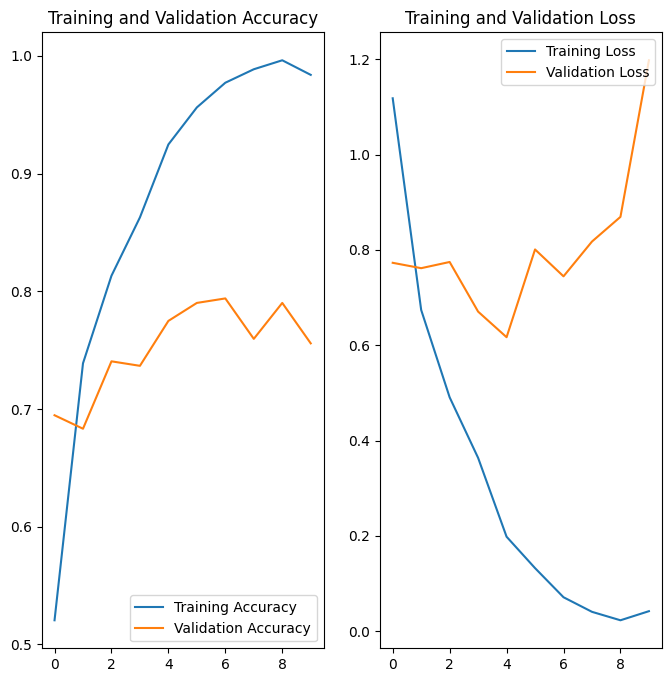

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augmentation

In [21]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),
    
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

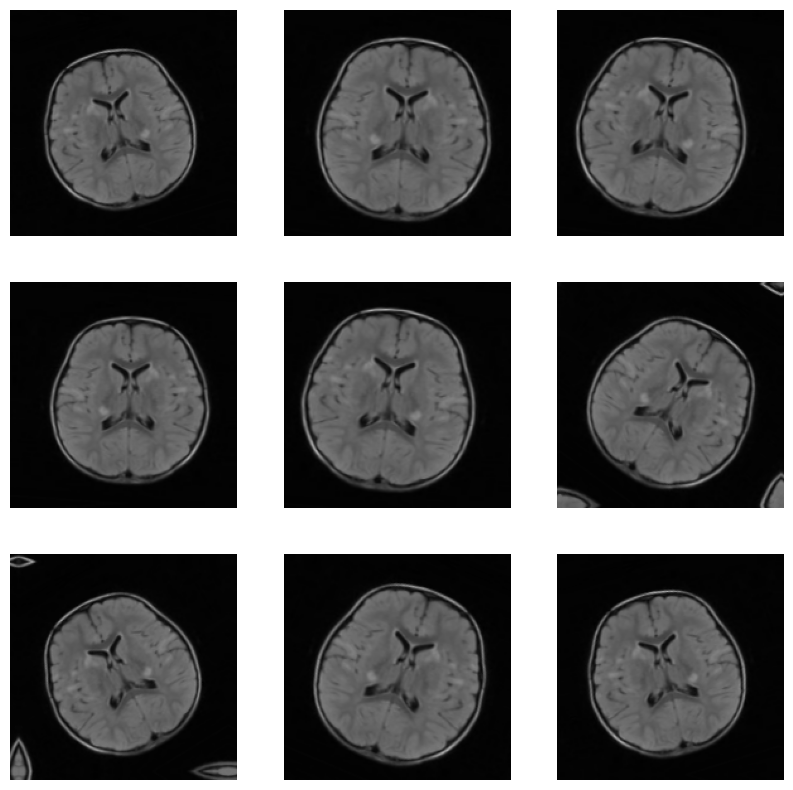

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Adding Dropout layer

In [23]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, name="outputs")
])

In [24]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [26]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/100


2023-10-03 11:51:10.527666: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - 3s 33ms/step - loss: 1.2272 - accuracy: 0.4223 - val_loss: 1.0720 - val_accuracy: 0.5687
Epoch 2/100
33/33 [==============================] - 1s 26ms/step - loss: 0.9430 - accuracy: 0.6168 - val_loss: 0.7387 - val_accuracy: 0.7023
Epoch 3/100
33/33 [==============================] - 1s 26ms/step - loss: 0.7787 - accuracy: 0.7026 - val_loss: 0.7442 - val_accuracy: 0.7137
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 0.7351 - accuracy: 0.7092 - val_loss: 0.6123 - val_accuracy: 0.7481
Epoch 5/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6357 - accuracy: 0.7483 - val_loss: 0.6371 - val_accuracy: 0.7366
Epoch 6/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6185 - accuracy: 0.7579 - val_loss: 0.8322 - val_accuracy: 0.6870
Epoch 7/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6156 - accuracy: 0.7626 - val_loss: 0.5744 - val_accuracy: 0.7443
Epoch 8/100
33/33 

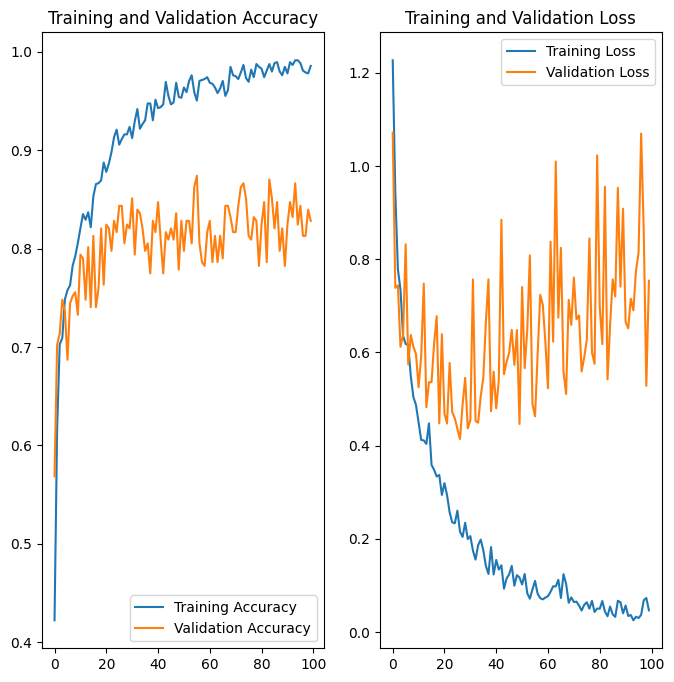

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [32]:
giloma_path = "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data/meningioma/Te-me_0015.jpg"


img = tf.keras.utils.load_img(
    giloma_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to meningioma with a 100.00 percent confidence.


In [35]:
## Convert the model to TfLite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

## Save the model
with open('brain_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [36]:
# Save the Keras model as an HDF5 file
model.save("brain_model.h5")